# About This Notebook
Updated May 13, 2020

This notebook showcases a model I built for the New York City Trip Duration Kaggle competition from 2017. The goal of this project is to predict the `trip duration` of each ride. 

Although this competition is now closed, I was able to do a late submission. The evaluation metric was RMSLE and my submission of the test set scored by Kaggle was 0.38019 (shown below), which would have put me in the top 14th percentile (position #177 of 1254)!
![NYC Cab Trip Duration Kaggle Competition Late Submission Score](./img/nyc_cab_score.png)

## Overview

__Data Preprocessing:__ 
- Used log of `trip_duration` as target/ label

__Feature Engineering:__
- *(FeaturizeLocations class)* Engineered 3 features from calculating distances between pickup and dropoff locations :
    - Great_circle_distance: shortest distance between two points on a sphere (going from point C to B directly)
    - Manhanttan_distance: sum of absolute distance along axes at right angles (going from point C to A then to B)
    - Bearing: direction from pickup to dropoff location


- *(ClusterLocations)* Engineered 4 features from location/ time clusters
    - Used mini-batch K-Means clustering with k=20 to split up locations into clusters.
    - Estimate density/ traffic by grouping rides in train data by pickup and dropoff clusters, day_of_week and hour_of_day to calculate:
        - num_rides_by_pickup_group : number of rides per pickup cluster and time group
        - perc_rides_by_pickup_group: percentage of rides per pickup cluster and time group of all rides in train set
        - num_rides_by_dropoff_group : number of rides per dropoff cluster and time group
        - perc_rides_by_dropoff_group: percentage of rides per dropoff cluster and time group of all rides in train set


- *(GetClusterProbability)* Engineered 40 features from pickup and dropoff latitude and longitude data
    - Used Standard Scaler to scale latitude and longitude
    - Initialized a Gaussian Mixture Model of 20 components and fit it to the train set
    - Fitted GMM returns probabilities of a data point belonging to each pickup/dropoff cluster.


- *(FeaturizeTime class)* Temporal Data: Engineered 7 features from ‘pickup_datetime’ column
        - Month, day, day_of_week, hour_of_day, minute_of_hour, is_holiday


- *(DummifyCategoricals class)* Categorical Data: Dummified 5 categorical variables 
        - Vendor_id, passenger_count, store_and_fwd_flag, pickup and dropoff clusters from 

__Feature Selection:__
- Used step-forward feature selection to select top 50 features out of a total of 62 features engineered.

__Final Model:__
- Trained LightGBM Regressor model
- Used gridsearchCV to tune hyperparameters


# EDA

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import time 
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import shap

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from shapely.geometry import Point, LineString
import geopandas as gpd
from geopandas import GeoSeries
import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import geocode
from haversine import haversine, Unit
import geo.sphere 
from geopy.geocoders import Nominatim

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture
from scipy.spatial.distance import pdist, squareform, euclidean, cosine
from scipy.cluster.hierarchy import linkage, dendrogram

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,8)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Descriptive Statistics

In [3]:
df = pd.read_csv('./data_nyc/train.csv')

In [4]:
df.shape

(1458644, 11)

In [5]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
pd.set_option('float_format', '{:f}'.format)

In [7]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000000,1458644.000000,1458644.000000,1458644.000000,1458644.000000,1458644.000000,1458644.000000
mean,1.534950,1.664530,-73.973486,40.750921,-73.973416,40.751800,959.492273
std,0.498777,1.314242,0.070902,0.032881,0.070643,0.035891,5237.431724
min,1.000000,0.000000,-121.933342,34.359695,-121.933304,32.181141,1.000000
25%,1.000000,1.000000,-73.991867,40.737347,-73.991325,40.735885,397.000000
50%,2.000000,1.000000,-73.981743,40.754101,-73.979752,40.754524,662.000000
75%,2.000000,2.000000,-73.967331,40.768360,-73.963013,40.769810,1075.000000
max,2.000000,9.000000,-61.335529,51.881084,-61.335529,43.921028,3526282.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## Explore Target Variable

In [9]:
target='trip_duration'


In [10]:
df[target].mean()


959.4922729603659

In [11]:
df[target].describe()


count   1458644.000000
mean        959.492273
std        5237.431724
min           1.000000
25%         397.000000
50%         662.000000
75%        1075.000000
max     3526282.000000
Name: trip_duration, dtype: float64

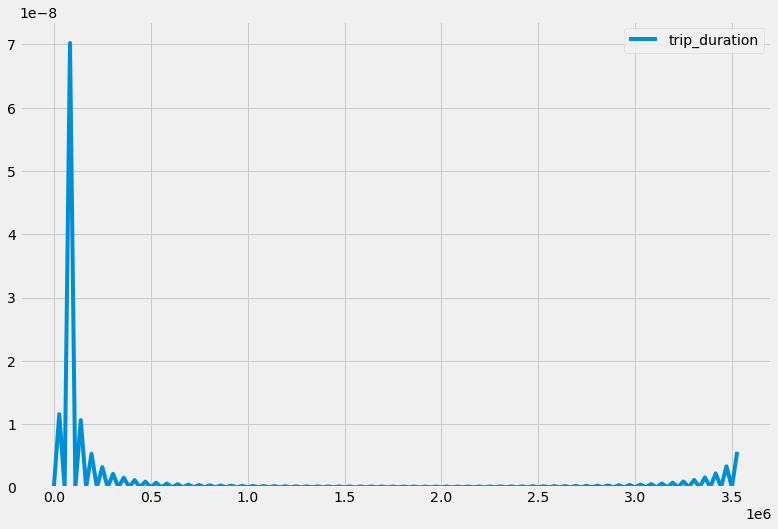

In [12]:
sns.kdeplot(df[target])


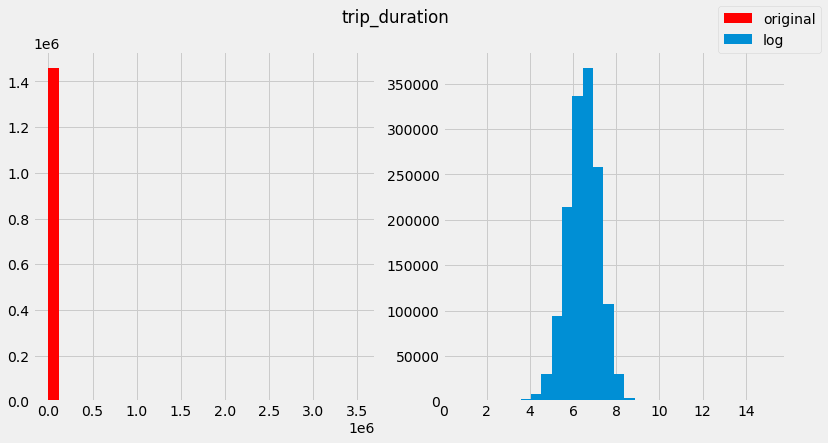

In [17]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].hist(df[target], bins=30, label='original', color='red')
ax[1].hist(np.log1p(df[target]), bins=30, label='log')
fig.suptitle(target)
fig.legend()

In [18]:
np.log1p(df[target]).value_counts()


5.910797     1624
6.013715     1584
5.855072     1582
5.908083     1581
5.883322     1577
             ... 
8.762959        1
11.329435       1
8.637285        1
11.335818       1
10.530361       1
Name: trip_duration, Length: 7417, dtype: int64

In [13]:
df['trip_duration_log'] = np.log1p(df['trip_duration'])
df.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642


## Pairplots

In [19]:
df.dtypes.value_counts()

float64    4
object     4
int64      3
dtype: int64

In [15]:
# Get numerical features
numerical_cols = df.dtypes[df.dtypes != 'object'].index

# Remove the target columns
numerical_cols = numerical_cols.drop(['trip_duration_log', 'trip_duration'])

In [22]:
numerical_cols

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude'],
      dtype='object')

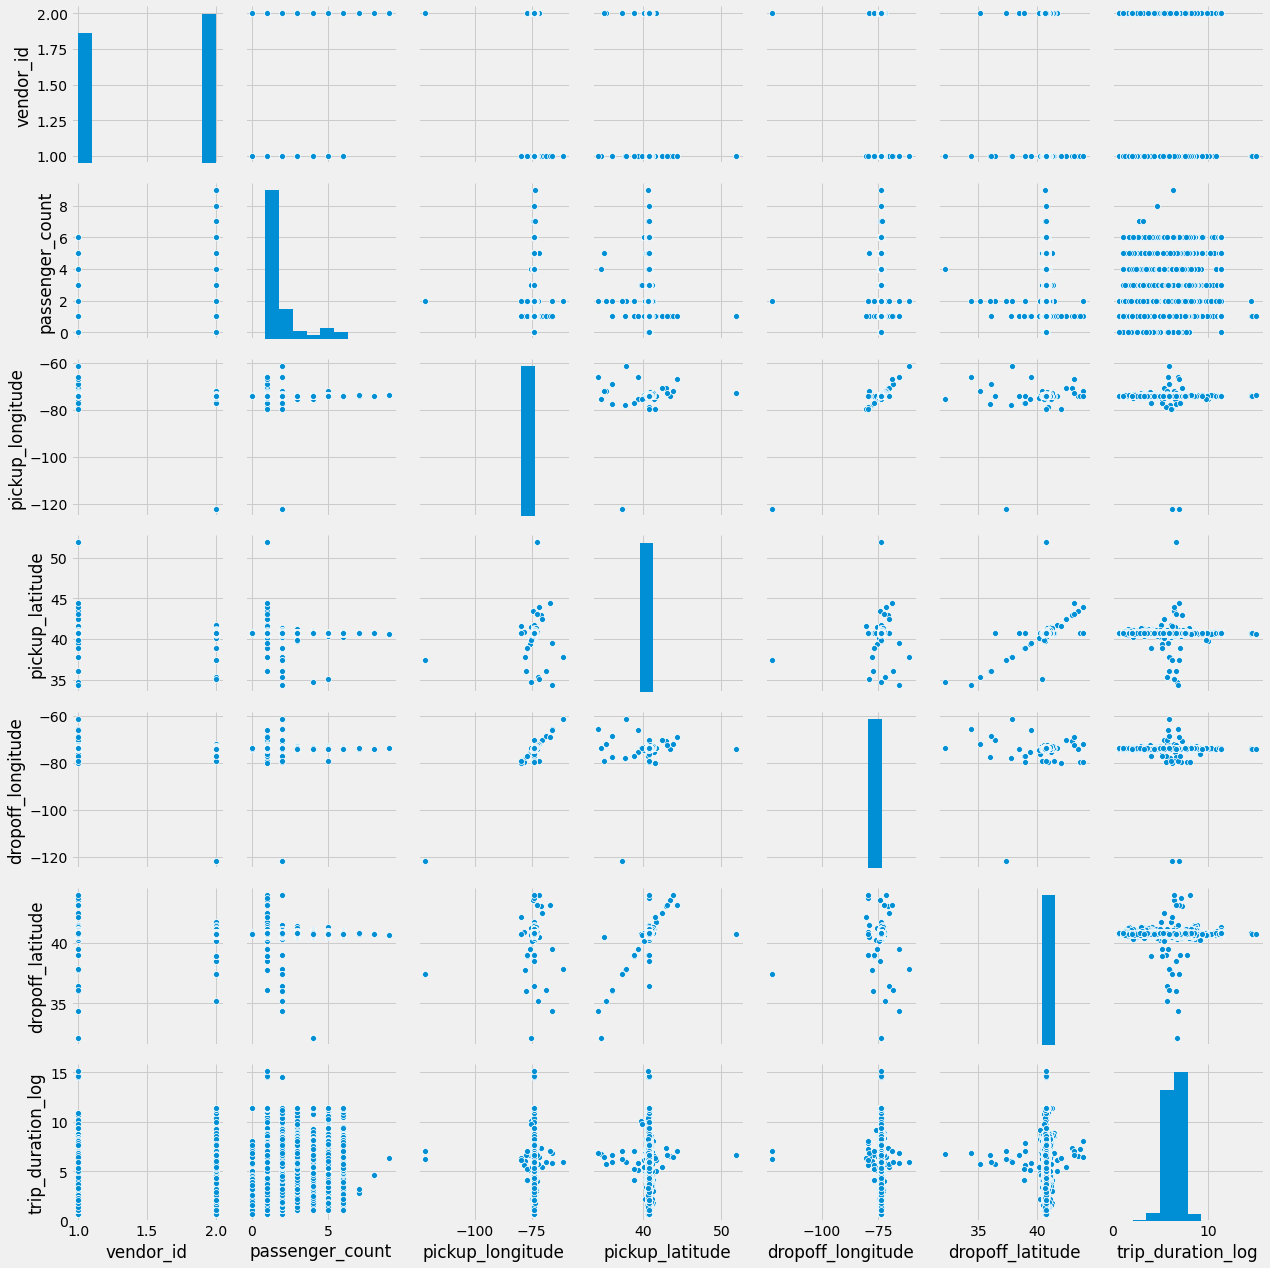

In [23]:
cols = list(numerical_cols) + ['trip_duration_log']
sns.pairplot(df.loc[:, cols])

## Plot Distribution of all Features and Label

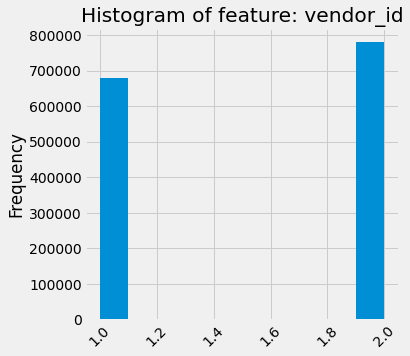

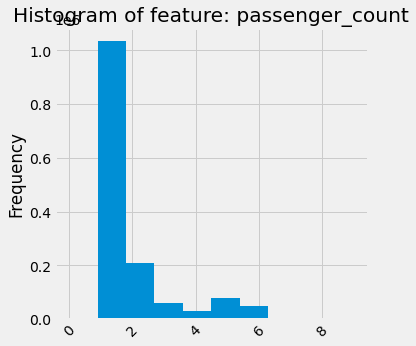

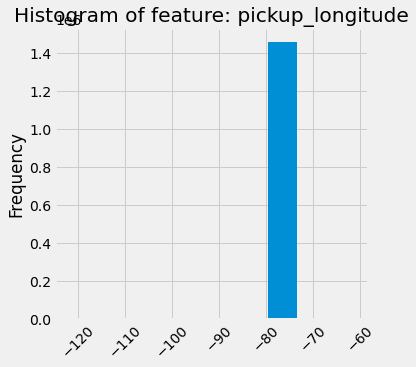

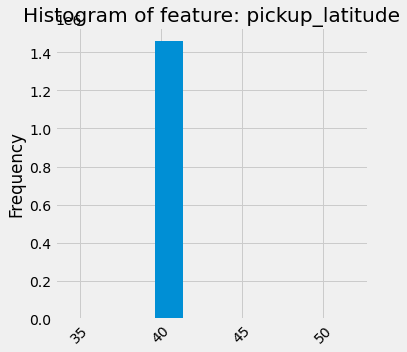

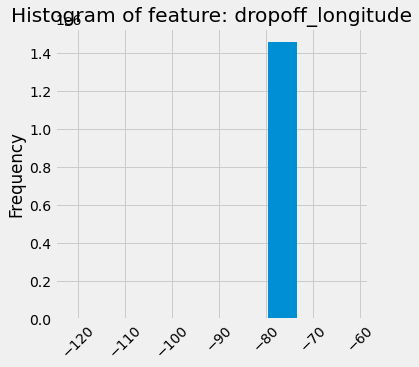

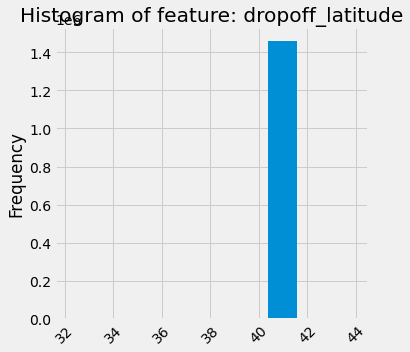

In [27]:
for col in df[numerical_cols].columns:
    fig, ax = plt.subplots(figsize=(5,5))
    df[col].hist(ax=ax)
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of feature: {col}')

## Nulls

In [16]:
null_summary = pd.concat((df.isnull().sum(), df.isnull().sum()/df.shape[0]), axis=1)
null_summary.columns = ['actual', 'pct']
null_summary['dtype'] = df.dtypes
null_summary

,actual,pct,dtype
id,0,0.000000,object
vendor_id,0,0.000000,int64
pickup_datetime,0,0.000000,object
dropoff_datetime,0,0.000000,object
passenger_count,0,0.000000,int64
pickup_longitude,0,0.000000,float64
pickup_latitude,0,0.000000,float64
dropoff_longitude,0,0.000000,float64
dropoff_latitude,0,0.000000,float64
store_and_fwd_flag,0,0.000000,object


## Correlation Matrix 

Start by creating a random variable to see where this falls in the correlation matrix

In [17]:
df['random'] = np.random.random(df.shape[0])

In [18]:
target_corr = df.corr()['trip_duration_log'].sort_values()
target_corr

pickup_latitude     -0.144853
dropoff_latitude    -0.123888
random               0.000788
vendor_id            0.019720
passenger_count      0.021044
dropoff_longitude    0.071901
pickup_longitude     0.110991
trip_duration        0.253521
trip_duration_log    1.000000
Name: trip_duration_log, dtype: float64

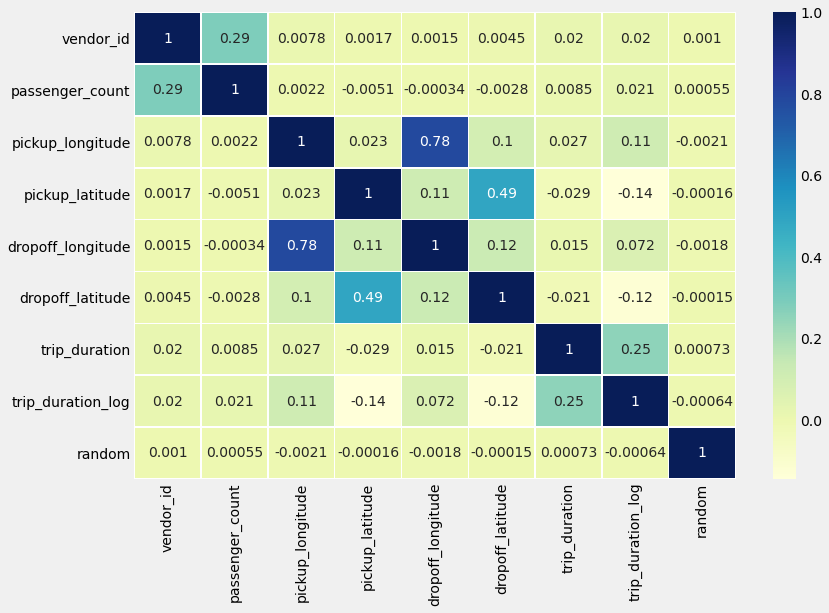

In [32]:
ax = sns.heatmap(df.corr(), annot=True, linewidths=0.5, cmap ='YlGnBu')

# Feature Engineering

## Time-based Features

In [19]:
import holidays

In [20]:
class FeaturizeTime(object):
    def fit(self, X, y):
        return self
        
    def transform(self, X):
        X = X.copy()
        # Engineer temporal features
        X['pickup_datetime'] = pd.to_datetime(X['pickup_datetime'])
        X['month'] = X['pickup_datetime'].dt.month
        X['day'] = X['pickup_datetime'].dt.day
        X['day_of_week'] = X['pickup_datetime'].dt.dayofweek
        X['hour_of_day'] = X['pickup_datetime'].dt.hour
        X['minute_of_hour'] = X['pickup_datetime'].dt.minute
        
        # Get holidays in NY state in 2016
        us_holidays = holidays.US(state='NY', years=2016)
        X['is_holiday'] = X['pickup_datetime'].dt.date.apply(lambda x: 1 if x in us_holidays.keys() else 0)
        
        # Drop time column in final df
        X = X.drop(['pickup_datetime'], axis=1)
        print('Time-based features transformed')
        return X 


## Calculate Distance Between Coordinates

The original dataset includes latitude and longitude for pickup and dropoff locations. I will use these to engineer the following location-based features:
- __Great Circle Distance between pickup and dropoff locations__ (`great_circle_distance`): I will calculate the great circle distance using geo-py's API between the pickup and dropoff lat/long coordinates - this is the shortest distance between two points on a sphere.


- __Manhattan Distance between pickup and dropoff locations__ (`manhattan_distance`): I will calculate the manhattan distance between the pickup and dropoff lat/long coordinates


- __Bearing between pickup and dropoff locations__ (`bearing`): I will calculate the bearing using geo-py's API between the pickup and dropoff lat/long coordinates - this is the direction from the pickup location to dropoff location.

In [21]:
class CalculateDistances(object):
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        ## 1) Find min distance between pickup and dropoff coordinates 
        X['great_circle_distance'] = X.apply(lambda x: self._calculate_great_circle_distance(x['pickup_latitude'], x['pickup_longitude'], 
                                                                       x['dropoff_latitude'], x['dropoff_longitude']),
                                                                       axis=1)
        
        ## 2) Calculate manhattan distance between pickup and dropoff coordinates
        X['manhattan_distance'] = X.apply(lambda x: self._calculate_manhattan_distance(x['pickup_latitude'], x['pickup_longitude'], 
                                                                       x['dropoff_latitude'], x['dropoff_longitude']),
                                                                       axis=1)
        
        ## 3) Calculate bearing between pickup and dropoff latitude
        X['bearing'] = X.apply(lambda x: self._calculate_bearing(x['pickup_latitude'], x['pickup_longitude'], 
                                                           x['dropoff_latitude'], x['dropoff_longitude']),
                                                           axis=1)
        print('Distance features calculated')
        return X
    
    def _calculate_great_circle_distance(self, pickup_lat, pickup_long, dropoff_lat, dropoff_long):
        pickup = [pickup_lat, pickup_long]
        dropoff = [dropoff_lat, dropoff_long]
        distance = geo.sphere.distance(pickup, dropoff)
        return distance
    
    def _calculate_manhattan_distance(self, pickup_lat, pickup_long, dropoff_lat, dropoff_long):
        pickup = [pickup_lat, pickup_long]
        dropoff_a = [pickup_lat, dropoff_long]
        dropoff_b = [dropoff_lat, pickup_long]
        distance_a = geo.sphere.distance(pickup, dropoff_a)
        distance_b = geo.sphere.distance(pickup, dropoff_b)
        return distance_a + distance_b
        
    def _calculate_bearing(self, pickup_lat, pickup_long, dropoff_lat, dropoff_long):
        pickup = [pickup_lat, pickup_long]
        dropoff = [dropoff_lat, dropoff_long]
        bearing = geo.sphere.bearing(pickup, dropoff)
        return bearing

## Find Cluster

In [22]:
class GetClusterDensity():
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.pickup_time_clusters = pd.DataFrame()
        self.dropoff_time_clusters = pd.DataFrame()
    
    def fit(self, X, y):
        # I. Fit pickup cluster
        df_pickup = X[['pickup_latitude', 'pickup_longitude']].copy()
        
        ## Ia. Initialize K-means 
        self.clf_pickup = MiniBatchKMeans(n_clusters=self.n_clusters, batch_size=10000, max_iter=300, random_state=1)
        self.clf_pickup.fit_predict(df_pickup)
        df_pickup['pickup_cluster'] = self.clf_pickup.labels_
        df_pickup['pickup_cluster'] = df_pickup['pickup_cluster'].astype(str)
        X = pd.merge(X, df_pickup[['pickup_cluster']], left_index=True, right_index=True, how='left')
        self.clf_pickup.fit(df_pickup.drop(['pickup_cluster'], axis=1))
        
        ## Ib. Calculate number of rides grouped by cluster and time as proxy for "density" of traffic by location and time
        pickup_time_clusters = pd.DataFrame(X.groupby(['month', 'day', 'hour_of_day', 'pickup_cluster'])['pickup_latitude'].count()).reset_index()
        pickup_time_clusters = pickup_time_clusters.rename(columns={'pickup_latitude': 'num_rides_by_pickup_group'})
        pickup_time_clusters_agg = pd.DataFrame(pickup_time_clusters.reset_index().groupby(['month', 'day'])['num_rides_by_pickup_group'].sum().round(4))
        pickup_time_clusters_agg = pickup_time_clusters_agg.rename(columns={'num_rides_by_pickup_group': 'agg_rides_per_day'})
        pickup_time_clusters = pd.merge(pickup_time_clusters.set_index(['month', 'day', 'hour_of_day']), pickup_time_clusters_agg, left_index=True, right_index=True)
        pickup_time_clusters['perc_rides_per_day_by_pickup_group'] = pickup_time_clusters['num_rides_by_pickup_group']/pickup_time_clusters['agg_rides_per_day']
        pickup_time_clusters = pickup_time_clusters.reset_index()
        pickup_time_clusters['pickup_group'] = pickup_time_clusters['pickup_cluster'].map(str) + str(',') + \
                            pickup_time_clusters['month'].map(str) + str(',') + pickup_time_clusters['day'].map(str) + \
                            str(',') + pickup_time_clusters['hour_of_day'].map(str)
        self.pickup_time_clusters = pickup_time_clusters
        
        
        # II. Fit dropoff cluster
        df_dropoff = X[['dropoff_latitude', 'dropoff_longitude']].copy()       
        
        ## IIa. Initialize K-means 
        self.clf_dropoff = MiniBatchKMeans(n_clusters=20, batch_size=10000, max_iter=300, random_state=1)
        self.clf_dropoff.fit_predict(df_dropoff)
        df_dropoff['dropoff_cluster'] = self.clf_dropoff.labels_
        df_dropoff['dropoff_cluster'] = df_dropoff['dropoff_cluster'].astype(str)
        X = pd.merge(X, df_dropoff[['dropoff_cluster']], left_index=True, right_index=True, how='left')
        self.clf_dropoff.fit(df_dropoff.drop(['dropoff_cluster'], axis=1))
        
        ## IIb. Calculate number of rides grouped by cluster and time as proxy for "density" of traffic by location and time
        dropoff_time_clusters = pd.DataFrame(X.groupby(['month', 'day', 'hour_of_day', 'dropoff_cluster'])['dropoff_latitude'].count()).reset_index()
        dropoff_time_clusters = dropoff_time_clusters.rename(columns={'dropoff_latitude': 'num_rides_by_dropoff_group'})
        dropoff_time_clusters_agg = pd.DataFrame(dropoff_time_clusters.reset_index().groupby(['month', 'day'])['num_rides_by_dropoff_group'].sum().round(4))
        dropoff_time_clusters_agg = dropoff_time_clusters_agg.rename(columns={'num_rides_by_dropoff_group': 'agg_rides_per_day'})
        dropoff_time_clusters = pd.merge(dropoff_time_clusters.set_index(['month', 'day', 'hour_of_day']), dropoff_time_clusters_agg, left_index=True, right_index=True)
        dropoff_time_clusters['perc_rides_per_day_by_dropoff_group'] = dropoff_time_clusters['num_rides_by_dropoff_group']/dropoff_time_clusters['agg_rides_per_day']
        dropoff_time_clusters = dropoff_time_clusters.reset_index()
        dropoff_time_clusters['dropoff_group'] = dropoff_time_clusters['dropoff_cluster'].map(str) + str(',') + \
                            dropoff_time_clusters['month'].map(str) + str(',') + dropoff_time_clusters['day'].map(str) + \
                            str(',') + dropoff_time_clusters['hour_of_day'].map(str)
        self.dropoff_time_clusters = dropoff_time_clusters
        
        return self
    
    def transform(self, X):
        # III. Predict pickup cluster
        df_pickup = X[['pickup_latitude', 'pickup_longitude']].copy()
        
        ## IIIa. Add cluster label
        df_pickup['pickup_cluster'] = self.clf_pickup.predict(df_pickup)
        df_pickup['pickup_cluster'] = df_pickup['pickup_cluster'].astype(str)
        
        ## IIIb. Merge cluster label back to original dataframe
        X = pd.merge(X, df_pickup[['pickup_cluster']], left_index=True, right_index=True, how='left')
        
        ## IIIc. Merge to create "num_rides_by_pickup_group" and "perc_rides_by_pickup_group" features
        X['pickup_group'] = X['pickup_cluster'].map(str) + str(',') + X['month'].map(str) + str(',') + \
                            X['day'].map(str) + str(',') + X['hour_of_day'].map(str)
        X = pd.merge(X, self.pickup_time_clusters[['pickup_group','num_rides_by_pickup_group', 'perc_rides_per_day_by_pickup_group']], on='pickup_group', how='left')
        X = X.drop(['pickup_group', 'pickup_cluster'], axis=1)
        print('Pickup Clusters Found')
        
        
        # IV. Predict dropoff cluster
        df_dropoff = X[['dropoff_latitude', 'dropoff_longitude']].copy() 
        
        ## IVa. Add cluster label
        df_dropoff['dropoff_cluster'] = self.clf_dropoff.predict(df_dropoff)
        df_dropoff['dropoff_cluster'] = df_dropoff['dropoff_cluster'].astype(str)
        
        ## IVb. Merge cluster label back to original dataframe
        X = pd.merge(X, df_dropoff[['dropoff_cluster']], left_index=True, right_index=True, how='left')
        
        ## IVc. Merge to create "num_rides_by_pickup_group" and "perc_rides_by_pickup_group" features
        X['dropoff_group'] = X['dropoff_cluster'].map(str) + str(',') + X['month'].map(str) + str(',') + \
                             X['day'].map(str) + str(',') + X['hour_of_day'].map(str)
        X = pd.merge(X, self.dropoff_time_clusters[['dropoff_group','num_rides_by_dropoff_group', 'perc_rides_per_day_by_dropoff_group']], on='dropoff_group', how='left')
        X = X.drop(['dropoff_group', 'dropoff_cluster'], axis=1)
        print('Dropoff Clusters Found')
        
        return X

## Gaussian Mixture Model

### GMM 

In [108]:
class GetClusterProbability():
    def __init__(self, n_components):
        self.n_components = n_components
    
    def fit(self, X, y):
        # Pickup locations
        self.pickup_cols = ['pickup_latitude', 'pickup_longitude']
        self.scaler_pickup = StandardScaler()
        pickup_scaled = self.scaler_pickup.fit_transform(X[self.pickup_cols])
        self.gmm_pickup = mixture.GaussianMixture(n_components=self.n_components).fit(pickup_scaled)
        
        # Dropoff locations
        self.dropoff_cols = ['dropoff_latitude', 'dropoff_longitude']
        self.scaler_dropoff = StandardScaler()
        dropoff_scaled = self.scaler_dropoff.fit_transform(X[self.dropoff_cols])
        self.gmm_dropoff = mixture.GaussianMixture(n_components=self.n_components).fit(dropoff_scaled)
        
        return self
    
    def transform(self, X):
        # Pickup locations
        pickup_scaled = self.scaler_pickup.transform(X[self.pickup_cols])
        preds_pickup = pd.DataFrame(self.gmm_pickup.predict_proba(pickup_scaled))
        preds_pickup = preds_pickup.add_prefix('gmm_pickup_')
        X = pd.merge(X, preds_pickup, left_index=True, right_index=True)
        print('GMM for pickup done')
        
        # Dropoff locations
        dropoff_scaled = self.scaler_dropoff.transform(X[self.dropoff_cols])
        preds_dropoff = pd.DataFrame(self.gmm_dropoff.predict_proba(dropoff_scaled))
        preds_dropoff = preds_dropoff.add_prefix('gmm_dropoff_')
        X = pd.merge(X, preds_dropoff, left_index=True, right_index=True)
        print('GMM for dropoff done')
        
        return X

## Dummify Categorical Features

In [24]:
class DummifyCategoricals():
    def fit(self, X, y):
        self.cols_to_encode=['vendor_id', 'store_and_fwd_flag']
        self.encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')
        
        transformed_array = self.encoder.fit_transform(X[self.cols_to_encode]).toarray()
        self.transformed_colnames = [f'{prefix}_{value}' 
                                     for prefix, values in zip(self.cols_to_encode, self.encoder.categories_) 
                                     for value in values]
            
        return self
        
    def transform(self, X):
        transformed_array = self.encoder.transform(X[self.cols_to_encode]).toarray()
        transformed_df = pd.DataFrame(transformed_array, columns=self.transformed_colnames)
        
        X = pd.concat((X.drop(self.cols_to_encode, axis=1).reset_index(drop=True), 
                       transformed_df.reset_index(drop=True)), axis=1)
        print('Categorical variables dummified')
        return X

# Modeling

## Super Naive Model

What is the RMSLE if we predicted the mean trip duration for our dataset?

In [19]:
# RMSLE for predicting mean of trip duration
np.sqrt(mean_squared_log_error(df['trip_duration'], np.repeat(df['trip_duration'].mean(), df.shape[0])))

0.890846228918568

In [20]:
# RMSLE for predicting mean of log of trip duration
np.sqrt(mean_squared_log_error(np.exp(df['trip_duration_log']), np.exp(np.repeat(df['trip_duration_log'].mean(), df.shape[0]))))

0.7923875354491517

Taking the natural log of the label improved the RMSLE by 11%! So, let's use the log form of the label to train our model

In [25]:
target = 'trip_duration_log'


## Naive Model

No feature engineering; just modeling with cross validation. Use a small sample of 10k observations to see how random forest does

In [158]:
rf_cv_mean = np.sqrt(-cross_val_score(estimator=RandomForestRegressor(),
                X=df[numerical_cols].sample(10000, random_state=1), 
                y=df[target].sample(10000, random_state=1),
                scoring='neg_mean_squared_error').mean())


In [159]:
print(f'Random Forest CV Mean RMSLE: {rf_cv_mean}')

Random Forest CV Mean RMSLE: 0.5300959795273942


## Model with Feature Engineering

## Train, test split

In [26]:
train, df_test = train_test_split(df)

df_train, df_valid = train_test_split(train)

df_train.shape, df_valid.shape, df_test.shape

((820487, 13), (273496, 13), (364661, 13))

In [27]:
# Remove original target from df_train and df_test
df_train = df_train.drop(['trip_duration'], axis=1)
df_valid = df_valid.drop(['trip_duration'], axis=1)
df_test = df_test.drop(['trip_duration'], axis=1)

In [28]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration_log,random
1380221,id2356013,1,2016-02-05 06:44:40,2016-02-05 07:22:56,1,-73.961807,40.758896,-73.786217,40.644032,N,7.739359,0.549422
942277,id2140089,2,2016-05-09 14:42:09,2016-05-09 14:48:00,1,-74.006477,40.733021,-73.992355,40.732170,N,5.863631,0.415464
728043,id1464033,2,2016-04-10 00:24:53,2016-04-10 00:53:48,5,-74.009026,40.713581,-73.935089,40.686531,N,7.459339,0.270093
1132687,id0783028,2,2016-05-03 00:32:25,2016-05-03 00:37:48,1,-73.955894,40.772205,-73.948410,40.769604,N,5.780744,0.336019
1380989,id2707240,2,2016-03-12 21:14:29,2016-03-12 21:21:41,6,-73.997246,40.755550,-73.988518,40.748539,N,6.070738,0.442754


In [29]:
initial_feats = ['vendor_id',
                 'pickup_datetime',
                 'passenger_count',
                 'pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude',
                 'store_and_fwd_flag']

## Data Preprocessing

In [109]:
half_pipeline = make_pipeline(
                        FeaturizeTime(),
                         CalculateDistances(),
                         GetClusterDensity(n_clusters=20),
                         GetClusterProbability(n_components=20),
                         DummifyCategoricals()
                        )

In [110]:
df_train_feat = half_pipeline.fit_transform(df_train[initial_feats])
df_valid_feat = half_pipeline.transform(df_valid[initial_feats])
df_test_feat = half_pipeline.transform(df_test[initial_feats])

Time-based features transformed
Distance features calculated
Pickup Clusters Found
Dropoff Clusters Found
GMM for pickup done
GMM for dropoff done
Categorical variables dummified
Time-based features transformed
Distance features calculated
Pickup Clusters Found
Dropoff Clusters Found
GMM for pickup done
GMM for dropoff done
Categorical variables dummified
Time-based features transformed
Distance features calculated
Pickup Clusters Found
Dropoff Clusters Found
GMM for pickup done
GMM for dropoff done
Categorical variables dummified


In [111]:
df_train_feat.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,day,day_of_week,hour_of_day,minute_of_hour,is_holiday,great_circle_distance,manhattan_distance,bearing,num_rides_by_pickup_group,perc_rides_per_day_by_pickup_group,num_rides_by_dropoff_group,perc_rides_per_day_by_dropoff_group,gmm_pickup_0,gmm_pickup_1,gmm_pickup_2,gmm_pickup_3,gmm_pickup_4,gmm_pickup_5,gmm_pickup_6,gmm_pickup_7,gmm_pickup_8,gmm_pickup_9,gmm_pickup_10,gmm_pickup_11,gmm_pickup_12,gmm_pickup_13,gmm_pickup_14,gmm_pickup_15,gmm_pickup_16,gmm_pickup_17,gmm_pickup_18,gmm_pickup_19,gmm_dropoff_0,gmm_dropoff_1,gmm_dropoff_2,gmm_dropoff_3,gmm_dropoff_4,gmm_dropoff_5,gmm_dropoff_6,gmm_dropoff_7,gmm_dropoff_8,gmm_dropoff_9,gmm_dropoff_10,gmm_dropoff_11,gmm_dropoff_12,gmm_dropoff_13,gmm_dropoff_14,gmm_dropoff_15,gmm_dropoff_16,gmm_dropoff_17,gmm_dropoff_18,gmm_dropoff_19,vendor_id_1,vendor_id_2,store_and_fwd_flag_N,store_and_fwd_flag_Y
0,1,-73.961807,40.758896,-73.786217,40.644032,2,5,4,6,44,0,19844.456184,23053.521118,349.646900,10,0.002110,4,0.000844,0.804055,0.000000,0.000000,0.000000,0.000000,0.000957,0.000000,0.000006,0.000000,0.000000,0.188707,0.000000,0.001517,0.001317,0.000000,0.000840,0.000000,0.000000,0.000000,0.002601,0.000000,0.000000,0.998942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000101,0.000000,1.000000,0.000000,1.000000,0.000000
1,1,-74.006477,40.733021,-73.992355,40.732170,5,9,0,14,42,0,1570.514409,1596.360530,359.048319,13,0.003218,14,0.003465,0.000000,0.000000,0.011043,0.000000,0.000000,0.001620,0.000000,0.000007,0.000000,0.103598,0.000000,0.000000,0.000034,0.000521,0.000000,0.000000,0.000000,0.000000,0.883176,0.000000,0.000004,0.167426,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.004800,0.003713,0.000000,0.000107,0.000268,0.000000,0.000000,0.823621,0.000000,0.000000,0.000060,0.000000,0.000000,1.000000,1.000000,0.000000
2,5,-74.009026,40.713581,-73.935089,40.686531,4,10,6,0,24,0,8263.209570,9049.985415,354.218846,13,0.002787,19,0.004073,0.000000,0.000000,0.973666,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.025701,0.000000,0.000000,0.000246,0.000211,0.000000,0.000000,0.000000,0.000000,0.000173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.191813,0.779077,0.000000,0.024885,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004224,0.000000,0.000000,1.000000,1.000000,0.000000
3,1,-73.955894,40.772205,-73.948410,40.769604,5,3,1,0,32,0,836.065900,912.185012,354.509948,7,0.001473,10,0.002105,0.015963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.980101,0.000000,0.000140,0.000413,0.000000,0.003345,0.000000,0.000000,0.000000,0.000036,0.000925,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001584,0.000875,0.972815,0.001763,0.021120,0.000000,0.000000,0.000000,0.000384,0.000000,0.000347,0.000186,0.000000,1.000000,1.000000,0.000000
4,6,-73.997246,40.755550,-73.988518,40.748539,3,12,5,21,14,0,994.040918,1185.446171,347.506093,11,0.002090,28,0.005319,0.000024,0.000000,0.000000,0.000000,0.000000,0.337919,0.000361,0.000005,0.000000,0.000005,0.000000,0.000000,0.000002,0.000471,0.000109,0.000000,0.000000,0.000000,0.069418,0.591688,0.081406,0.898312,0.000000,0.000000,0.000003,0.000000,0.000456,0.000000,0.001652,0.000779,0.000002,0.000090,0.000765,0.000000,0.000000,0.016493,0.000000,0.000000,0.000042,0.000000,0.000000,1.000000,1.000000,0.000000


## Define Error Metric Calculation

In [33]:
def calc_rmsle(y_true_log, y_preds_log):
    return np.sqrt(mean_squared_log_error(np.exp(y_true_log), np.exp(y_preds_log)))

## Pipeline LightGBM Model

In [112]:
lgb = LGBMRegressor()
lgb.fit(df_train_feat, df_train[target], eval_set=[(df_valid_feat, df_valid[target])], 
        eval_metric='rmse', early_stopping_rounds=10, verbose=1)

[1]	valid_0's rmse: 0.750261	valid_0's l2: 0.562892
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 0.710146	valid_0's l2: 0.504308
[3]	valid_0's rmse: 0.675538	valid_0's l2: 0.456352
[4]	valid_0's rmse: 0.646478	valid_0's l2: 0.417934
[5]	valid_0's rmse: 0.620965	valid_0's l2: 0.385598
[6]	valid_0's rmse: 0.598946	valid_0's l2: 0.358736
[7]	valid_0's rmse: 0.57963	valid_0's l2: 0.335971
[8]	valid_0's rmse: 0.563039	valid_0's l2: 0.317013
[9]	valid_0's rmse: 0.548147	valid_0's l2: 0.300465
[10]	valid_0's rmse: 0.535768	valid_0's l2: 0.287048
[11]	valid_0's rmse: 0.524984	valid_0's l2: 0.275608
[12]	valid_0's rmse: 0.514557	valid_0's l2: 0.264769
[13]	valid_0's rmse: 0.506259	valid_0's l2: 0.256298
[14]	valid_0's rmse: 0.498897	valid_0's l2: 0.248898
[15]	valid_0's rmse: 0.492588	valid_0's l2: 0.242643
[16]	valid_0's rmse: 0.486975	valid_0's l2: 0.237145
[17]	valid_0's rmse: 0.481601	valid_0's l2: 0.231939
[18]	valid_0's rmse: 0.477038	valid_0's l2: 0.22

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [113]:
y_preds_lgbm = lgb.predict(df_test_feat)

In [114]:
calc_rmsle(df_test[target], y_preds_lgbm)

0.4029377708858435

# Hyperparameter Tuning and Feature Selection

## Feature Selection

In [115]:
best_feats = df_train_feat.columns[np.argsort(lgb.feature_importances_)[::-1]]
best_feats

Index(['bearing', 'hour_of_day', 'manhattan_distance', 'great_circle_distance',
       'day_of_week', 'gmm_pickup_12', 'gmm_dropoff_6', 'gmm_pickup_6',
       'month', 'dropoff_latitude', 'day', 'pickup_latitude', 'gmm_dropoff_4',
       'gmm_dropoff_12', 'num_rides_by_dropoff_group', 'gmm_dropoff_0',
       'gmm_dropoff_11', 'gmm_dropoff_8', 'pickup_longitude', 'gmm_dropoff_9',
       'dropoff_longitude', 'gmm_pickup_9', 'gmm_dropoff_18', 'gmm_dropoff_10',
       'gmm_pickup_13', 'num_rides_by_pickup_group', 'gmm_dropoff_15',
       'gmm_dropoff_19', 'gmm_pickup_19', 'vendor_id_1', 'gmm_pickup_0',
       'is_holiday', 'minute_of_hour', 'gmm_pickup_18', 'gmm_pickup_14',
       'gmm_pickup_5', 'gmm_dropoff_7', 'gmm_pickup_10',
       'perc_rides_per_day_by_pickup_group', 'gmm_pickup_15', 'gmm_dropoff_1',
       'gmm_pickup_2', 'passenger_count', 'gmm_dropoff_5', 'gmm_dropoff_16',
       'gmm_pickup_7', 'vendor_id_2', 'perc_rides_per_day_by_dropoff_group',
       'gmm_dropoff_2', 'gmm_pi

In [116]:
features_intersection = [col for col in df_train_feat[df_train_feat.columns.intersection(df_test_feat.columns)].columns]

In [117]:
best_feats_intersection = [feat for feat in best_feats if feat in features_intersection]
print(len(best_feats_intersection))
best_feats_intersection

62


['bearing',
 'hour_of_day',
 'manhattan_distance',
 'great_circle_distance',
 'day_of_week',
 'gmm_pickup_12',
 'gmm_dropoff_6',
 'gmm_pickup_6',
 'month',
 'dropoff_latitude',
 'day',
 'pickup_latitude',
 'gmm_dropoff_4',
 'gmm_dropoff_12',
 'num_rides_by_dropoff_group',
 'gmm_dropoff_0',
 'gmm_dropoff_11',
 'gmm_dropoff_8',
 'pickup_longitude',
 'gmm_dropoff_9',
 'dropoff_longitude',
 'gmm_pickup_9',
 'gmm_dropoff_18',
 'gmm_dropoff_10',
 'gmm_pickup_13',
 'num_rides_by_pickup_group',
 'gmm_dropoff_15',
 'gmm_dropoff_19',
 'gmm_pickup_19',
 'vendor_id_1',
 'gmm_pickup_0',
 'is_holiday',
 'minute_of_hour',
 'gmm_pickup_18',
 'gmm_pickup_14',
 'gmm_pickup_5',
 'gmm_dropoff_7',
 'gmm_pickup_10',
 'perc_rides_per_day_by_pickup_group',
 'gmm_pickup_15',
 'gmm_dropoff_1',
 'gmm_pickup_2',
 'passenger_count',
 'gmm_dropoff_5',
 'gmm_dropoff_16',
 'gmm_pickup_7',
 'vendor_id_2',
 'perc_rides_per_day_by_dropoff_group',
 'gmm_dropoff_2',
 'gmm_pickup_1',
 'store_and_fwd_flag_N',
 'gmm_pickup_3',
 'gmm_dropoff_14',
 'gmm_dropoff_17',
 'gmm_dropoff_13',
 'gmm_pickup_17',
 'gmm_dropoff_3',
 'gmm_pickup_16',
 'gmm_pickup_11',
 'gmm_pickup_8',
 'gmm_pickup_4',
 'store_and_fwd_flag_Y']

In [118]:
best_feats_intersection[42:]

['passenger_count',
 'gmm_dropoff_5',
 'gmm_dropoff_16',
 'gmm_pickup_7',
 'vendor_id_2',
 'perc_rides_per_day_by_dropoff_group',
 'gmm_dropoff_2',
 'gmm_pickup_1',
 'store_and_fwd_flag_N',
 'gmm_pickup_3',
 'gmm_dropoff_14',
 'gmm_dropoff_17',
 'gmm_dropoff_13',
 'gmm_pickup_17',
 'gmm_dropoff_3',
 'gmm_pickup_16',
 'gmm_pickup_11',
 'gmm_pickup_8',
 'gmm_pickup_4',
 'store_and_fwd_flag_Y']

In [119]:
train_scores = []
test_scores = []

for i in range(1, len(best_feats_intersection)):
    lgb.fit(df_train_feat.loc[:, best_feats_intersection[:i]], df_train[target])
    train_preds = lgb.predict(df_train_feat.loc[:, best_feats_intersection[:i]])
    train_scores.append(calc_rmsle(df_train[target],train_preds))
    test_preds = lgb.predict(df_test_feat.loc[:, best_feats_intersection[:i]])
    test_scores.append(calc_rmsle(df_test[target], test_preds))
    print(f'RMSLE recorded for round {i}')

RMSLE recorded for round 1
RMSLE recorded for round 2
RMSLE recorded for round 3
RMSLE recorded for round 4
RMSLE recorded for round 5
RMSLE recorded for round 6
RMSLE recorded for round 7
RMSLE recorded for round 8
RMSLE recorded for round 9
RMSLE recorded for round 10
RMSLE recorded for round 11
RMSLE recorded for round 12
RMSLE recorded for round 13
RMSLE recorded for round 14
RMSLE recorded for round 15
RMSLE recorded for round 16
RMSLE recorded for round 17
RMSLE recorded for round 18
RMSLE recorded for round 19
RMSLE recorded for round 20
RMSLE recorded for round 21
RMSLE recorded for round 22
RMSLE recorded for round 23
RMSLE recorded for round 24
RMSLE recorded for round 25
RMSLE recorded for round 26
RMSLE recorded for round 27
RMSLE recorded for round 28
RMSLE recorded for round 29
RMSLE recorded for round 30
RMSLE recorded for round 31
RMSLE recorded for round 32
RMSLE recorded for round 33
RMSLE recorded for round 34
RMSLE recorded for round 35
RMSLE recorded for round 36
R

In [120]:
len(test_scores)

61

(0.39, 0.45)

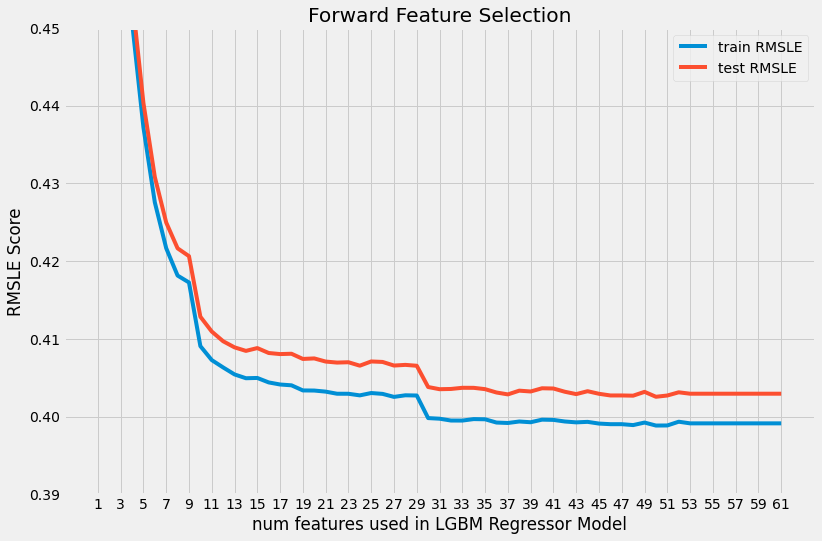

In [121]:
plt.plot(range(1, len(best_feats_intersection)), train_scores, label='train RMSLE')
plt.plot(range(1, len(best_feats_intersection)), test_scores, label='test RMSLE')

plt.xticks(np.arange(1,len(best_feats_intersection),2))
plt.xlabel('num features used in LGBM Regressor Model')
plt.ylabel('RMSLE Score')
plt.legend()
plt.title('Forward Feature Selection')
plt.ylim(0.39,0.45)
plt.savefig('./plots/step_forward_feat_sel.png', bbox_inches='tight')

In [122]:
min(test_scores)


0.40254258286047195

In [123]:
best_n_feats = test_scores.index(min(test_scores)) + 1
best_n_feats

50

In [124]:
X_train = df_train_feat.loc[:, best_feats_intersection[:best_n_feats]]
X_valid = df_valid_feat.loc[:, best_feats_intersection[:best_n_feats]]
X_test = df_test_feat.loc[:, best_feats_intersection[:best_n_feats]]

y_train = df_train[target]
y_valid = df_valid[target]
y_test = df_test[target]


In [125]:
X_train.shape, X_valid.shape, X_test.shape


((820487, 50), (273496, 50), (364661, 50))

## Hyperparameter Tuning

In [370]:
params = {
    'num_leaves': [256,512,1024], 
    'max_depth': [8,10,12], 
    'n_estimators': [500],
    'subsample': [0.8],
    'feature_fraction': [0.9],
    'lambda_l1': [0.2],
    'learning_rate': [0.1]
}


In [371]:
def calc_rmsle(y_true_log, y_preds_log):
    return np.sqrt(mean_squared_log_error(np.exp(y_true_log), np.exp(y_preds_log)))


In [374]:
rmsle_scorer = metrics.make_scorer(calc_rmsle, greater_is_better=False)


lgb = LGBMRegressor(eval_metric='rmse')
reg = GridSearchCV(lgb, params, scoring=rmsle_scorer, verbose=True)
reg.fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 37.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, eval_metric='rmse',
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_...
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'feature_fraction': [0.9], 'lambda_l1': [0.2],
                         'learning_rate': [0.1], 'max_depth': [8, 10, 12],
                         'n_est

In [375]:
reg.best_score_

-0.3770201986777685

In [376]:
reg.best_params_

{'feature_fraction': 0.9,
 'lambda_l1': 0.2,
 'learning_rate': 0.1,
 'max_depth': 12,
 'n_estimators': 500,
 'num_leaves': 512,
 'subsample': 0.8}

In [382]:
lgb_cv_results = pd.DataFrame.from_dict(reg.cv_results_).sort_values(by='mean_test_score', ascending=False)
lgb_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_fraction,param_lambda_l1,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,55.179262,1.525717,5.483923,0.083113,0.9,0.2,0.1,12,500,512,0.8,"{'feature_fraction': 0.9, 'lambda_l1': 0.2, 'l...",-0.378115,-0.377990,-0.375741,-0.372886,-0.380369,-0.377020,0.002533,1
4,50.020517,1.000877,5.589802,0.817763,0.9,0.2,0.1,10,500,512,0.8,"{'feature_fraction': 0.9, 'lambda_l1': 0.2, 'l...",-0.378316,-0.378858,-0.376536,-0.373765,-0.380070,-0.377509,0.002191,2
3,42.780306,0.855043,4.440606,0.082127,0.9,0.2,0.1,10,500,256,0.8,"{'feature_fraction': 0.9, 'lambda_l1': 0.2, 'l...",-0.378347,-0.378982,-0.376626,-0.374093,-0.380584,-0.377726,0.002215,3
8,65.345325,2.610003,7.606689,0.461258,0.9,0.2,0.1,12,500,1024,0.8,"{'feature_fraction': 0.9, 'lambda_l1': 0.2, 'l...",-0.378722,-0.379682,-0.375892,-0.374238,-0.380314,-0.377770,0.002325,4
6,37.674890,0.190001,3.268336,0.056007,0.9,0.2,0.1,12,500,256,0.8,"{'feature_fraction': 0.9, 'lambda_l1': 0.2, 'l...",-0.378812,-0.378349,-0.376689,-0.374615,-0.380573,-0.377808,0.002020,5
5,46.813295,0.270557,5.138931,0.057748,0.9,0.2,0.1,10,500,1024,0.8,"{'feature_fraction': 0.9, 'lambda_l1': 0.2, 'l...",-0.378582,-0.378620,-0.376740,-0.375049,-0.380930,-0.377984,0.001980,6
0,34.648728,1.247372,3.713286,0.185375,0.9,0.2,0.1,8,500,256,0.8,"{'feature_fraction': 0.9, 'lambda_l1': 0.2, 'l...",-0.380303,-0.380637,-0.378956,-0.375827,-0.382890,-0.379723,0.002323,7
1,35.125530,0.923840,3.979813,0.592713,0.9,0.2,0.1,8,500,512,0.8,"{'feature_fraction': 0.9, 'lambda_l1': 0.2, 'l...",-0.380303,-0.380637,-0.378956,-0.375827,-0.382890,-0.379723,0.002323,7
2,36.188066,1.326412,3.770486,0.184948,0.9,0.2,0.1,8,500,1024,0.8,"{'feature_fraction': 0.9, 'lambda_l1': 0.2, 'l...",-0.380303,-0.380637,-0.378956,-0.375827,-0.382890,-0.379723,0.002323,7


# Final Model

In [126]:
best_params_1 = {'feature_fraction': 0.9, 'lambda_l1': 0.2, 'learning_rate': 0.1, 'max_depth': 12,
               'n_estimators': 500, 'num_leaves': 512, 'subsample': 0.8}

In [127]:
final_lgb_1 = LGBMRegressor(eval_metric='rmse', **best_params_1)


In [128]:
final_lgb_1.fit(X_train, y_train,
              early_stopping_rounds=10,
              eval_set=[(X_train, y_train),(X_valid, y_valid)])


[1]	training's l2: 0.551794	valid_1's l2: 0.552112
Training until validation scores don't improve for 10 rounds
[2]	training's l2: 0.484075	valid_1's l2: 0.484832
[3]	training's l2: 0.429072	valid_1's l2: 0.430284
[4]	training's l2: 0.383619	valid_1's l2: 0.385317
[5]	training's l2: 0.346151	valid_1's l2: 0.348387
[6]	training's l2: 0.315411	valid_1's l2: 0.318149
[7]	training's l2: 0.289996	valid_1's l2: 0.29314
[8]	training's l2: 0.27017	valid_1's l2: 0.27379
[9]	training's l2: 0.2523	valid_1's l2: 0.256308
[10]	training's l2: 0.237476	valid_1's l2: 0.241916
[11]	training's l2: 0.225122	valid_1's l2: 0.229981
[12]	training's l2: 0.214769	valid_1's l2: 0.220035
[13]	training's l2: 0.206191	valid_1's l2: 0.211898
[14]	training's l2: 0.198727	valid_1's l2: 0.204857
[15]	training's l2: 0.192442	valid_1's l2: 0.198983
[16]	training's l2: 0.186903	valid_1's l2: 0.193801
[17]	training's l2: 0.182119	valid_1's l2: 0.189388
[18]	training's l2: 0.177826	valid_1's l2: 0.185494
[19]	training's l

[159]	training's l2: 0.105515	valid_1's l2: 0.144379
[160]	training's l2: 0.105341	valid_1's l2: 0.144326
[161]	training's l2: 0.105123	valid_1's l2: 0.144262
[162]	training's l2: 0.104948	valid_1's l2: 0.144206
[163]	training's l2: 0.104869	valid_1's l2: 0.144204
[164]	training's l2: 0.104707	valid_1's l2: 0.144198
[165]	training's l2: 0.10458	valid_1's l2: 0.144188
[166]	training's l2: 0.104432	valid_1's l2: 0.144163
[167]	training's l2: 0.104264	valid_1's l2: 0.14416
[168]	training's l2: 0.104212	valid_1's l2: 0.144155
[169]	training's l2: 0.104048	valid_1's l2: 0.144129
[170]	training's l2: 0.103927	valid_1's l2: 0.144114
[171]	training's l2: 0.103824	valid_1's l2: 0.144112
[172]	training's l2: 0.103657	valid_1's l2: 0.144076
[173]	training's l2: 0.103521	valid_1's l2: 0.144051
[174]	training's l2: 0.103373	valid_1's l2: 0.144021
[175]	training's l2: 0.10328	valid_1's l2: 0.144004
[176]	training's l2: 0.103226	valid_1's l2: 0.143998
[177]	training's l2: 0.103072	valid_1's l2: 0.143

[312]	training's l2: 0.088445	valid_1's l2: 0.142614
[313]	training's l2: 0.0883319	valid_1's l2: 0.142598
[314]	training's l2: 0.0882125	valid_1's l2: 0.142569
[315]	training's l2: 0.0881789	valid_1's l2: 0.142568
[316]	training's l2: 0.0880714	valid_1's l2: 0.14257
[317]	training's l2: 0.0879557	valid_1's l2: 0.142537
[318]	training's l2: 0.0879032	valid_1's l2: 0.142546
[319]	training's l2: 0.0877731	valid_1's l2: 0.14254
[320]	training's l2: 0.0876811	valid_1's l2: 0.142531
[321]	training's l2: 0.0875896	valid_1's l2: 0.142529
[322]	training's l2: 0.0875094	valid_1's l2: 0.142522
[323]	training's l2: 0.0874278	valid_1's l2: 0.142518
[324]	training's l2: 0.0873228	valid_1's l2: 0.1425
[325]	training's l2: 0.0872308	valid_1's l2: 0.142483
[326]	training's l2: 0.087159	valid_1's l2: 0.142474
[327]	training's l2: 0.0870696	valid_1's l2: 0.14247
[328]	training's l2: 0.0869866	valid_1's l2: 0.142471
[329]	training's l2: 0.0869308	valid_1's l2: 0.142462
[330]	training's l2: 0.086882	valid

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              eval_metric='rmse', feature_fraction=0.9, importance_type='split',
              lambda_l1=0.2, learning_rate=0.1, max_depth=12,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=512, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [129]:
y_preds_1 = final_lgb_1.predict(X_test)


In [131]:
best_params_2 = {'feature_fraction': 0.9, 'lambda_l1': 0.2, 'learning_rate': 0.1, 'max_depth': 10,
               'n_estimators': 500, 'num_leaves': 512, 'subsample': 0.8}

In [132]:
final_lgb_2 = LGBMRegressor(eval_metric='rmse', **best_params_2)


In [133]:
final_lgb_2.fit(X_train, y_train,
              early_stopping_rounds=10,
              eval_set=[(X_train, y_train),(X_valid, y_valid)])


[1]	training's l2: 0.552835	valid_1's l2: 0.553107
Training until validation scores don't improve for 10 rounds
[2]	training's l2: 0.485832	valid_1's l2: 0.486543
[3]	training's l2: 0.431349	valid_1's l2: 0.432504
[4]	training's l2: 0.386291	valid_1's l2: 0.387859
[5]	training's l2: 0.349477	valid_1's l2: 0.35139
[6]	training's l2: 0.319189	valid_1's l2: 0.321418
[7]	training's l2: 0.293838	valid_1's l2: 0.296396
[8]	training's l2: 0.274182	valid_1's l2: 0.27713
[9]	training's l2: 0.256259	valid_1's l2: 0.259601
[10]	training's l2: 0.241502	valid_1's l2: 0.245143
[11]	training's l2: 0.229227	valid_1's l2: 0.233166
[12]	training's l2: 0.218851	valid_1's l2: 0.223095
[13]	training's l2: 0.210064	valid_1's l2: 0.214575
[14]	training's l2: 0.202678	valid_1's l2: 0.207452
[15]	training's l2: 0.196485	valid_1's l2: 0.20151
[16]	training's l2: 0.190832	valid_1's l2: 0.196226
[17]	training's l2: 0.186088	valid_1's l2: 0.191773
[18]	training's l2: 0.181869	valid_1's l2: 0.187805
[19]	training's

[159]	training's l2: 0.113574	valid_1's l2: 0.145321
[160]	training's l2: 0.113412	valid_1's l2: 0.14527
[161]	training's l2: 0.113303	valid_1's l2: 0.145236
[162]	training's l2: 0.113108	valid_1's l2: 0.145209
[163]	training's l2: 0.112942	valid_1's l2: 0.145132
[164]	training's l2: 0.11277	valid_1's l2: 0.145122
[165]	training's l2: 0.112667	valid_1's l2: 0.145094
[166]	training's l2: 0.112545	valid_1's l2: 0.145078
[167]	training's l2: 0.112429	valid_1's l2: 0.145042
[168]	training's l2: 0.11239	valid_1's l2: 0.14503
[169]	training's l2: 0.112232	valid_1's l2: 0.145007
[170]	training's l2: 0.112159	valid_1's l2: 0.144999
[171]	training's l2: 0.112066	valid_1's l2: 0.14498
[172]	training's l2: 0.111798	valid_1's l2: 0.144916
[173]	training's l2: 0.111665	valid_1's l2: 0.144869
[174]	training's l2: 0.111516	valid_1's l2: 0.144823
[175]	training's l2: 0.111335	valid_1's l2: 0.144837
[176]	training's l2: 0.111167	valid_1's l2: 0.144794
[177]	training's l2: 0.111116	valid_1's l2: 0.14478

[315]	training's l2: 0.0983462	valid_1's l2: 0.143064
[316]	training's l2: 0.0982611	valid_1's l2: 0.143059
[317]	training's l2: 0.0981544	valid_1's l2: 0.14304
[318]	training's l2: 0.0980806	valid_1's l2: 0.14303
[319]	training's l2: 0.0979962	valid_1's l2: 0.143025
[320]	training's l2: 0.0979397	valid_1's l2: 0.143031
[321]	training's l2: 0.0978659	valid_1's l2: 0.143021
[322]	training's l2: 0.0977925	valid_1's l2: 0.143025
[323]	training's l2: 0.0977496	valid_1's l2: 0.143018
[324]	training's l2: 0.0976129	valid_1's l2: 0.142986
[325]	training's l2: 0.0975397	valid_1's l2: 0.142975
[326]	training's l2: 0.0975158	valid_1's l2: 0.142975
[327]	training's l2: 0.0974587	valid_1's l2: 0.142961
[328]	training's l2: 0.0973678	valid_1's l2: 0.14296
[329]	training's l2: 0.0972919	valid_1's l2: 0.142949
[330]	training's l2: 0.0972097	valid_1's l2: 0.142939
[331]	training's l2: 0.0971853	valid_1's l2: 0.142949
[332]	training's l2: 0.0970839	valid_1's l2: 0.142937
[333]	training's l2: 0.0970266	

[469]	training's l2: 0.0891176	valid_1's l2: 0.142382
[470]	training's l2: 0.0891077	valid_1's l2: 0.142382
[471]	training's l2: 0.0890433	valid_1's l2: 0.142385
[472]	training's l2: 0.0889984	valid_1's l2: 0.142389
[473]	training's l2: 0.0889354	valid_1's l2: 0.142375
[474]	training's l2: 0.0889008	valid_1's l2: 0.142377
[475]	training's l2: 0.0888573	valid_1's l2: 0.142377
[476]	training's l2: 0.0888211	valid_1's l2: 0.142371
[477]	training's l2: 0.0887921	valid_1's l2: 0.142373
[478]	training's l2: 0.0887464	valid_1's l2: 0.142367
[479]	training's l2: 0.0886791	valid_1's l2: 0.142364
[480]	training's l2: 0.0886226	valid_1's l2: 0.142365
[481]	training's l2: 0.0885885	valid_1's l2: 0.142359
[482]	training's l2: 0.0885573	valid_1's l2: 0.142362
[483]	training's l2: 0.0885295	valid_1's l2: 0.142365
[484]	training's l2: 0.0885191	valid_1's l2: 0.14237
[485]	training's l2: 0.0884695	valid_1's l2: 0.142371
[486]	training's l2: 0.0883842	valid_1's l2: 0.142352
[487]	training's l2: 0.088277

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              eval_metric='rmse', feature_fraction=0.9, importance_type='split',
              lambda_l1=0.2, learning_rate=0.1, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=512, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [134]:
y_preds_2 = final_lgb_2.predict(X_test)


In [135]:
best_params_3 = {'feature_fraction': 0.9, 'lambda_l1': 0.2, 'learning_rate': 0.1, 'max_depth': 10,
               'n_estimators': 500, 'num_leaves': 256, 'subsample': 0.8}

In [136]:
final_lgb_3 = LGBMRegressor(eval_metric='rmse', **best_params_3)


In [137]:
final_lgb_3.fit(X_train, y_train,
              early_stopping_rounds=10,
              eval_set=[(X_train, y_train),(X_valid, y_valid)])


[1]	training's l2: 0.554176	valid_1's l2: 0.554238
Training until validation scores don't improve for 10 rounds
[2]	training's l2: 0.488499	valid_1's l2: 0.488878
[3]	training's l2: 0.434834	valid_1's l2: 0.435391
[4]	training's l2: 0.390534	valid_1's l2: 0.391299
[5]	training's l2: 0.354176	valid_1's l2: 0.355163
[6]	training's l2: 0.324328	valid_1's l2: 0.325472
[7]	training's l2: 0.299408	valid_1's l2: 0.300684
[8]	training's l2: 0.280082	valid_1's l2: 0.281562
[9]	training's l2: 0.262585	valid_1's l2: 0.264279
[10]	training's l2: 0.248091	valid_1's l2: 0.249899
[11]	training's l2: 0.235927	valid_1's l2: 0.237932
[12]	training's l2: 0.225794	valid_1's l2: 0.22796
[13]	training's l2: 0.216967	valid_1's l2: 0.219372
[14]	training's l2: 0.2097	valid_1's l2: 0.212324
[15]	training's l2: 0.203501	valid_1's l2: 0.20634
[16]	training's l2: 0.197938	valid_1's l2: 0.200912
[17]	training's l2: 0.193152	valid_1's l2: 0.196376
[18]	training's l2: 0.189118	valid_1's l2: 0.192518
[19]	training's 

[159]	training's l2: 0.122603	valid_1's l2: 0.146565
[160]	training's l2: 0.122436	valid_1's l2: 0.146533
[161]	training's l2: 0.122317	valid_1's l2: 0.146515
[162]	training's l2: 0.122191	valid_1's l2: 0.14649
[163]	training's l2: 0.122154	valid_1's l2: 0.146482
[164]	training's l2: 0.121977	valid_1's l2: 0.146448
[165]	training's l2: 0.121857	valid_1's l2: 0.146425
[166]	training's l2: 0.121729	valid_1's l2: 0.146378
[167]	training's l2: 0.121575	valid_1's l2: 0.146339
[168]	training's l2: 0.121485	valid_1's l2: 0.146308
[169]	training's l2: 0.121333	valid_1's l2: 0.146277
[170]	training's l2: 0.121107	valid_1's l2: 0.146192
[171]	training's l2: 0.121014	valid_1's l2: 0.146182
[172]	training's l2: 0.120913	valid_1's l2: 0.146153
[173]	training's l2: 0.120785	valid_1's l2: 0.146136
[174]	training's l2: 0.120662	valid_1's l2: 0.146102
[175]	training's l2: 0.120551	valid_1's l2: 0.146074
[176]	training's l2: 0.120369	valid_1's l2: 0.146031
[177]	training's l2: 0.12028	valid_1's l2: 0.14

[315]	training's l2: 0.107582	valid_1's l2: 0.143883
[316]	training's l2: 0.107495	valid_1's l2: 0.143871
[317]	training's l2: 0.107414	valid_1's l2: 0.14386
[318]	training's l2: 0.107347	valid_1's l2: 0.143854
[319]	training's l2: 0.107238	valid_1's l2: 0.14382
[320]	training's l2: 0.107177	valid_1's l2: 0.143821
[321]	training's l2: 0.107089	valid_1's l2: 0.143802
[322]	training's l2: 0.106994	valid_1's l2: 0.143782
[323]	training's l2: 0.106927	valid_1's l2: 0.143773
[324]	training's l2: 0.106825	valid_1's l2: 0.143761
[325]	training's l2: 0.106809	valid_1's l2: 0.143762
[326]	training's l2: 0.106754	valid_1's l2: 0.143761
[327]	training's l2: 0.106675	valid_1's l2: 0.143754
[328]	training's l2: 0.106606	valid_1's l2: 0.143754
[329]	training's l2: 0.106522	valid_1's l2: 0.143742
[330]	training's l2: 0.106414	valid_1's l2: 0.143724
[331]	training's l2: 0.106379	valid_1's l2: 0.143726
[332]	training's l2: 0.106349	valid_1's l2: 0.143716
[333]	training's l2: 0.106277	valid_1's l2: 0.14

[470]	training's l2: 0.097522	valid_1's l2: 0.142964
[471]	training's l2: 0.0974928	valid_1's l2: 0.142967
[472]	training's l2: 0.0974316	valid_1's l2: 0.14296
[473]	training's l2: 0.0973598	valid_1's l2: 0.142955
[474]	training's l2: 0.0972773	valid_1's l2: 0.142949
[475]	training's l2: 0.0972582	valid_1's l2: 0.142953
[476]	training's l2: 0.0972048	valid_1's l2: 0.142945
[477]	training's l2: 0.0971323	valid_1's l2: 0.142935
[478]	training's l2: 0.0970804	valid_1's l2: 0.142935
[479]	training's l2: 0.0970476	valid_1's l2: 0.142926
[480]	training's l2: 0.0969977	valid_1's l2: 0.14292
[481]	training's l2: 0.0969512	valid_1's l2: 0.142917
[482]	training's l2: 0.0969055	valid_1's l2: 0.142905
[483]	training's l2: 0.096864	valid_1's l2: 0.142905
[484]	training's l2: 0.0967888	valid_1's l2: 0.142906
[485]	training's l2: 0.0967408	valid_1's l2: 0.1429
[486]	training's l2: 0.0966856	valid_1's l2: 0.142888
[487]	training's l2: 0.0966584	valid_1's l2: 0.142886
[488]	training's l2: 0.0966134	val

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              eval_metric='rmse', feature_fraction=0.9, importance_type='split',
              lambda_l1=0.2, learning_rate=0.1, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=256, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [138]:
y_preds_3 = final_lgb_3.predict(X_test)


In [139]:
best_params_4 = {'feature_fraction': 0.9, 'lambda_l1': 0.2, 'learning_rate': 0.1, 'max_depth': 12,
               'n_estimators': 500, 'num_leaves': 1024, 'subsample': 0.8}

In [140]:
final_lgb_4 = LGBMRegressor(eval_metric='rmse', **best_params_4)


In [141]:
final_lgb_4.fit(X_train, y_train,
              early_stopping_rounds=10,
              eval_set=[(X_train, y_train),(X_valid, y_valid)])


[1]	training's l2: 0.550148	valid_1's l2: 0.550819
Training until validation scores don't improve for 10 rounds
[2]	training's l2: 0.481006	valid_1's l2: 0.482425
[3]	training's l2: 0.424899	valid_1's l2: 0.427181
[4]	training's l2: 0.378394	valid_1's l2: 0.381397
[5]	training's l2: 0.340219	valid_1's l2: 0.344066
[6]	training's l2: 0.308902	valid_1's l2: 0.31339
[7]	training's l2: 0.283043	valid_1's l2: 0.28821
[8]	training's l2: 0.26291	valid_1's l2: 0.268697
[9]	training's l2: 0.244753	valid_1's l2: 0.251246
[10]	training's l2: 0.229759	valid_1's l2: 0.236878
[11]	training's l2: 0.217189	valid_1's l2: 0.224937
[12]	training's l2: 0.206585	valid_1's l2: 0.214848
[13]	training's l2: 0.197672	valid_1's l2: 0.20649
[14]	training's l2: 0.190181	valid_1's l2: 0.199584
[15]	training's l2: 0.184034	valid_1's l2: 0.193962
[16]	training's l2: 0.178338	valid_1's l2: 0.188824
[17]	training's l2: 0.17356	valid_1's l2: 0.184535
[18]	training's l2: 0.169327	valid_1's l2: 0.180889
[19]	training's l

[157]	training's l2: 0.0934713	valid_1's l2: 0.143858
[158]	training's l2: 0.0933135	valid_1's l2: 0.143833
[159]	training's l2: 0.0931762	valid_1's l2: 0.143803
[160]	training's l2: 0.0930542	valid_1's l2: 0.14379
[161]	training's l2: 0.0929273	valid_1's l2: 0.14376
[162]	training's l2: 0.0927459	valid_1's l2: 0.14374
[163]	training's l2: 0.0925481	valid_1's l2: 0.143697
[164]	training's l2: 0.0924133	valid_1's l2: 0.143697
[165]	training's l2: 0.092289	valid_1's l2: 0.143677
[166]	training's l2: 0.092238	valid_1's l2: 0.143667
[167]	training's l2: 0.0920396	valid_1's l2: 0.143641
[168]	training's l2: 0.091867	valid_1's l2: 0.143609
[169]	training's l2: 0.0916607	valid_1's l2: 0.143573
[170]	training's l2: 0.091538	valid_1's l2: 0.143566
[171]	training's l2: 0.0912829	valid_1's l2: 0.143526
[172]	training's l2: 0.0910897	valid_1's l2: 0.143501
[173]	training's l2: 0.0909258	valid_1's l2: 0.143466
[174]	training's l2: 0.0907793	valid_1's l2: 0.143455
[175]	training's l2: 0.0905863	vali

[310]	training's l2: 0.0766134	valid_1's l2: 0.14234
[311]	training's l2: 0.0765083	valid_1's l2: 0.142331
[312]	training's l2: 0.0764388	valid_1's l2: 0.142329
[313]	training's l2: 0.0763753	valid_1's l2: 0.14234
[314]	training's l2: 0.0762703	valid_1's l2: 0.142333
[315]	training's l2: 0.076131	valid_1's l2: 0.142348
[316]	training's l2: 0.0760729	valid_1's l2: 0.142341
[317]	training's l2: 0.0759387	valid_1's l2: 0.14231
[318]	training's l2: 0.0758575	valid_1's l2: 0.142298
[319]	training's l2: 0.0757483	valid_1's l2: 0.142304
[320]	training's l2: 0.0756707	valid_1's l2: 0.142298
[321]	training's l2: 0.0756296	valid_1's l2: 0.142293
[322]	training's l2: 0.0755326	valid_1's l2: 0.142283
[323]	training's l2: 0.0754391	valid_1's l2: 0.142264
[324]	training's l2: 0.0753829	valid_1's l2: 0.142279
[325]	training's l2: 0.0753019	valid_1's l2: 0.142271
[326]	training's l2: 0.0751814	valid_1's l2: 0.142259
[327]	training's l2: 0.0751342	valid_1's l2: 0.14226
[328]	training's l2: 0.0750668	va

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              eval_metric='rmse', feature_fraction=0.9, importance_type='split',
              lambda_l1=0.2, learning_rate=0.1, max_depth=12,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=1024, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [142]:
y_preds_4 = final_lgb_4.predict(X_test)


In [143]:
best_params_5 = {'feature_fraction': 0.9, 'lambda_l1': 0.2, 'learning_rate': 0.1, 'max_depth': 12,
               'n_estimators': 500, 'num_leaves': 256, 'subsample': 0.8}

In [144]:
final_lgb_5 = LGBMRegressor(eval_metric='rmse', **best_params_5)


In [145]:
final_lgb_5.fit(X_train, y_train,
              early_stopping_rounds=10,
              eval_set=[(X_train, y_train),(X_valid, y_valid)])


[1]	training's l2: 0.553758	valid_1's l2: 0.553841
Training until validation scores don't improve for 10 rounds
[2]	training's l2: 0.487883	valid_1's l2: 0.488281
[3]	training's l2: 0.434104	valid_1's l2: 0.434703
[4]	training's l2: 0.389758	valid_1's l2: 0.390569
[5]	training's l2: 0.353313	valid_1's l2: 0.354365
[6]	training's l2: 0.323497	valid_1's l2: 0.324676
[7]	training's l2: 0.298658	valid_1's l2: 0.3
[8]	training's l2: 0.279309	valid_1's l2: 0.280862
[9]	training's l2: 0.26174	valid_1's l2: 0.263556
[10]	training's l2: 0.247185	valid_1's l2: 0.249185
[11]	training's l2: 0.234821	valid_1's l2: 0.237043
[12]	training's l2: 0.224581	valid_1's l2: 0.226974
[13]	training's l2: 0.215961	valid_1's l2: 0.218557
[14]	training's l2: 0.208604	valid_1's l2: 0.21142
[15]	training's l2: 0.202312	valid_1's l2: 0.205394
[16]	training's l2: 0.196778	valid_1's l2: 0.200086
[17]	training's l2: 0.192017	valid_1's l2: 0.195578
[18]	training's l2: 0.187767	valid_1's l2: 0.191713
[19]	training's l2:

[158]	training's l2: 0.11978	valid_1's l2: 0.146302
[159]	training's l2: 0.119645	valid_1's l2: 0.146268
[160]	training's l2: 0.11946	valid_1's l2: 0.146205
[161]	training's l2: 0.119326	valid_1's l2: 0.14614
[162]	training's l2: 0.1192	valid_1's l2: 0.146098
[163]	training's l2: 0.119099	valid_1's l2: 0.146091
[164]	training's l2: 0.118956	valid_1's l2: 0.146056
[165]	training's l2: 0.11888	valid_1's l2: 0.146046
[166]	training's l2: 0.118768	valid_1's l2: 0.146016
[167]	training's l2: 0.118637	valid_1's l2: 0.14598
[168]	training's l2: 0.118527	valid_1's l2: 0.145987
[169]	training's l2: 0.118374	valid_1's l2: 0.145956
[170]	training's l2: 0.118264	valid_1's l2: 0.145943
[171]	training's l2: 0.118144	valid_1's l2: 0.145924
[172]	training's l2: 0.117977	valid_1's l2: 0.145904
[173]	training's l2: 0.117829	valid_1's l2: 0.145864
[174]	training's l2: 0.117719	valid_1's l2: 0.145853
[175]	training's l2: 0.117607	valid_1's l2: 0.145825
[176]	training's l2: 0.1175	valid_1's l2: 0.145822
[1

[315]	training's l2: 0.104612	valid_1's l2: 0.14369
[316]	training's l2: 0.104572	valid_1's l2: 0.143681
[317]	training's l2: 0.104464	valid_1's l2: 0.143649
[318]	training's l2: 0.1044	valid_1's l2: 0.143658
[319]	training's l2: 0.104335	valid_1's l2: 0.143665
[320]	training's l2: 0.104229	valid_1's l2: 0.14365
[321]	training's l2: 0.104129	valid_1's l2: 0.143649
[322]	training's l2: 0.104042	valid_1's l2: 0.143635
[323]	training's l2: 0.103968	valid_1's l2: 0.143633
[324]	training's l2: 0.103872	valid_1's l2: 0.143635
[325]	training's l2: 0.103774	valid_1's l2: 0.143617
[326]	training's l2: 0.10369	valid_1's l2: 0.1436
[327]	training's l2: 0.103629	valid_1's l2: 0.143596
[328]	training's l2: 0.103537	valid_1's l2: 0.143584
[329]	training's l2: 0.103443	valid_1's l2: 0.143556
[330]	training's l2: 0.103419	valid_1's l2: 0.143548
[331]	training's l2: 0.103349	valid_1's l2: 0.143551
[332]	training's l2: 0.103281	valid_1's l2: 0.143542
[333]	training's l2: 0.103222	valid_1's l2: 0.143538


[470]	training's l2: 0.0947918	valid_1's l2: 0.142913
Early stopping, best iteration is:
[460]	training's l2: 0.0953199	valid_1's l2: 0.142906


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              eval_metric='rmse', feature_fraction=0.9, importance_type='split',
              lambda_l1=0.2, learning_rate=0.1, max_depth=12,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=256, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [146]:
y_preds_5 = final_lgb_5.predict(X_test)


In [147]:
y_preds_final = 0.2 * y_preds_1 + 0.2 * y_preds_2 + 0.2 * y_preds_3 + 0.2 * y_preds_4 + 0.2 * y_preds_5

In [148]:
calc_rmsle(y_test, y_preds_final)

0.3732281897132485

## Summary Plots

### Plot y_true vs. y_preds

Text(0.5, 1.0, 'Final LightGBM Model: actuals vs. preds on log scale')

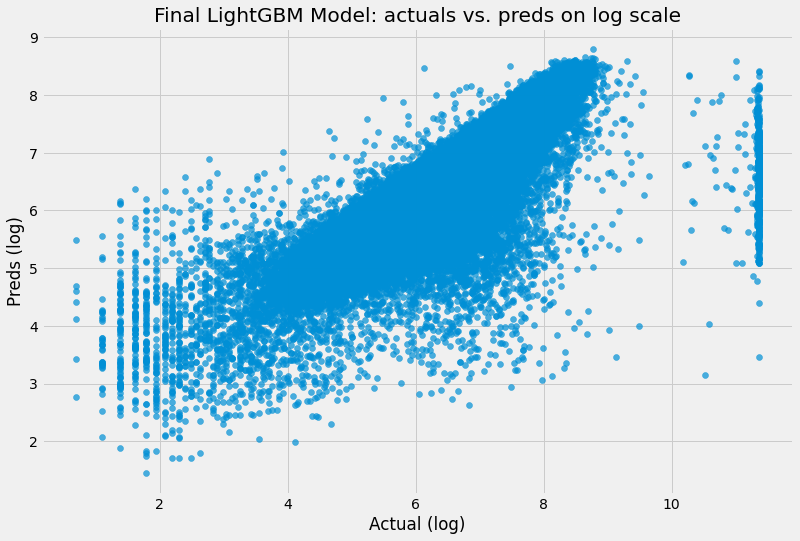

In [157]:
fig, ax = plt.subplots()
ax.scatter(y_test,y_preds_final, alpha=0.7)
ax.set_xlabel('Actual (log)')
ax.set_ylabel('Preds (log)')
ax.set_title('Final LightGBM Model: actuals vs. preds on log scale')
plt.savefig('./plots/residuals_plot.png', bbox_inches='tight')

## Feature Importances

In [158]:
explainer_1 = shap.TreeExplainer(final_lgb_1)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [159]:
examples = X_test.sample(10000)
shap_values_1 = explainer_1.shap_values(examples)


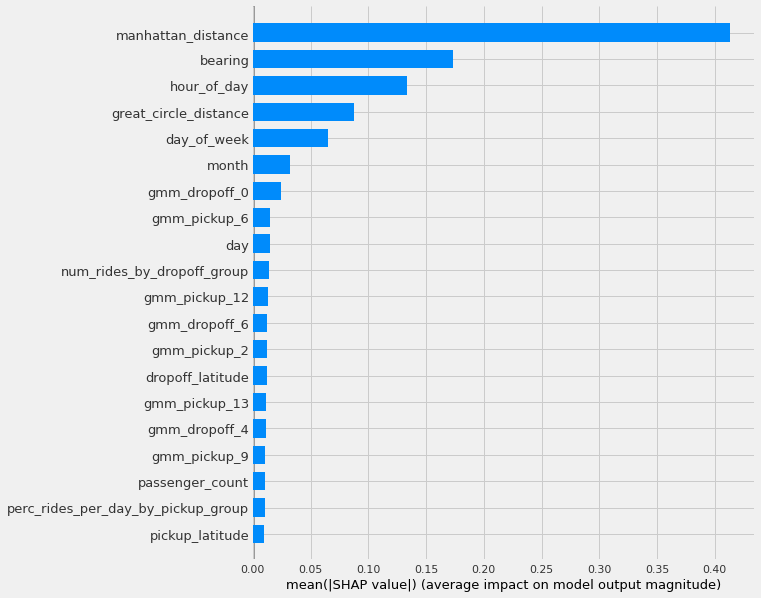

In [162]:
fig = shap.summary_plot(shap_values_1, examples, plot_type='bar', show=False)


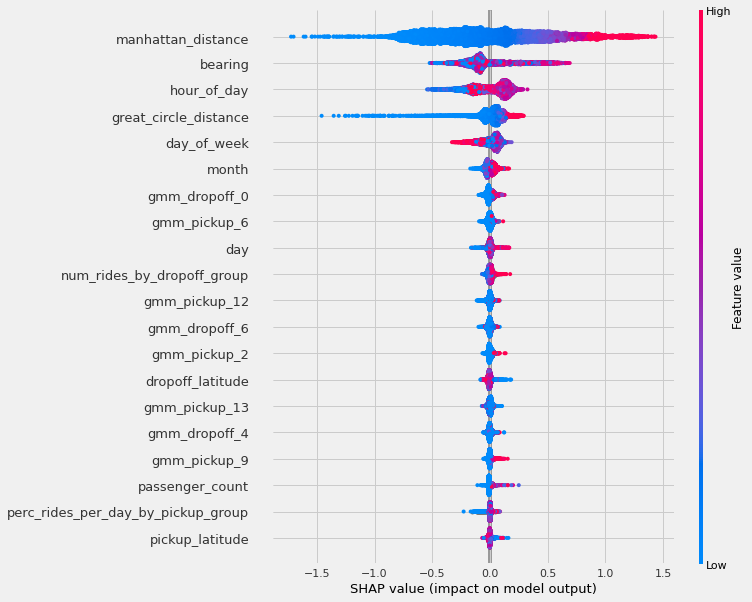

In [163]:
fig = shap.summary_plot(shap_values_1, examples, show=False)

# Submit Predictions to .csv for Kaggle

In [72]:
df_test_actual = pd.read_csv('./data_nyc/test.csv')
df_test_actual.shape

(625134, 9)

In [73]:
df_test_actual.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [149]:
df_test_actual_feat = half_pipeline.transform(df_test_actual[initial_feats])

Time-based features transformed
Distance features calculated
Pickup Clusters Found
Dropoff Clusters Found
GMM for pickup done
GMM for dropoff done
Categorical variables dummified


In [150]:
df_test_actual_feat.loc[:,best_feats_intersection[:best_n_feats]].head()

,bearing,hour_of_day,manhattan_distance,great_circle_distance,day_of_week,gmm_pickup_12,gmm_dropoff_6,gmm_pickup_6,month,dropoff_latitude,day,pickup_latitude,gmm_dropoff_4,gmm_dropoff_12,num_rides_by_dropoff_group,gmm_dropoff_0,gmm_dropoff_11,gmm_dropoff_8,pickup_longitude,gmm_dropoff_9,dropoff_longitude,gmm_pickup_9,gmm_dropoff_18,gmm_dropoff_10,gmm_pickup_13,num_rides_by_pickup_group,gmm_dropoff_15,gmm_dropoff_19,gmm_pickup_19,vendor_id_1,gmm_pickup_0,is_holiday,minute_of_hour,gmm_pickup_18,gmm_pickup_14,gmm_pickup_5,gmm_dropoff_7,gmm_pickup_10,perc_rides_per_day_by_pickup_group,gmm_pickup_15,gmm_dropoff_1,gmm_pickup_2,passenger_count,gmm_dropoff_5,gmm_dropoff_16,gmm_pickup_7,vendor_id_2,perc_rides_per_day_by_dropoff_group,gmm_dropoff_2,gmm_pickup_1
0,106.749322,23,983.432207,789.473665,3,0.000615,0.068850,0.000000,6,40.756680,30,40.732029,0.000019,0.000501,22.000000,0.385540,0.000104,0.001323,-73.988129,0.000372,-73.990173,0.846188,0.000056,0.000001,0.000368,19.000000,0.000972,0.000001,0.000000,1.000000,0.000009,0,59,0.113236,0.000000,0.039581,0.000000,0.000000,0.004400,0.000000,0.542262,0.000000,1,0.000000,0.000000,0.000003,0.000000,0.005095,0.000000,0.000000
1,302.886040,23,1243.949718,899.671375,3,0.940302,0.000000,0.000000,6,40.655403,30,40.679993,0.000000,0.000000,4.000000,0.000000,0.002235,0.830039,-73.964203,0.162650,-73.959808,0.000000,0.005074,0.000000,0.059207,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0,59,0.000000,0.000000,0.000000,0.000001,0.000000,0.000926,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000491,0.000000,0.000926,0.000000,0.000000
2,348.844466,23,1500.950597,1277.993177,3,0.000038,0.000000,0.000000,6,40.729523,30,40.737583,0.000000,0.000340,32.000000,0.000002,0.000206,0.009166,-73.997437,0.009275,-73.986160,0.095614,0.000091,0.000000,0.000243,13.000000,0.855942,0.000000,0.000015,1.000000,0.000006,0,59,0.829844,0.000000,0.074193,0.000000,0.000000,0.003011,0.000000,0.124977,0.000045,1,0.000000,0.000000,0.000002,0.000000,0.007411,0.000000,0.000000
3,200.628779,23,4648.837480,3607.322622,3,0.000146,0.000000,0.000000,6,40.730469,30,40.771900,0.000000,0.000389,32.000000,0.000005,0.000197,0.008428,-73.956070,0.008274,-73.986427,0.000000,0.000087,0.000000,0.000420,4.000000,0.822068,0.000000,0.000043,0.000000,0.018718,0,59,0.000000,0.000000,0.000000,0.000000,0.977444,0.000926,0.003227,0.160552,0.000000,1,0.000000,0.000000,0.000002,1.000000,0.007411,0.000000,0.000000
4,349.948785,23,1139.447819,983.048299,3,0.000060,0.000000,0.000000,6,40.755890,30,40.761475,0.000000,0.023230,14.000000,0.637981,0.001069,0.004459,-73.970215,0.003769,-73.961510,0.000000,0.000215,0.312779,0.000252,20.000000,0.000001,0.000017,0.041584,1.000000,0.941407,0,59,0.000000,0.000004,0.002233,0.000000,0.014411,0.004632,0.000047,0.016480,0.000000,1,0.000000,0.000000,0.000001,0.000000,0.003242,0.000000,0.000000


In [151]:
preds_1 = final_lgb_1.predict(df_test_actual_feat.loc[:,best_feats_intersection[:best_n_feats]])
preds_2 = final_lgb_2.predict(df_test_actual_feat.loc[:,best_feats_intersection[:best_n_feats]])
preds_3 = final_lgb_3.predict(df_test_actual_feat.loc[:,best_feats_intersection[:best_n_feats]])
preds_4 = final_lgb_4.predict(df_test_actual_feat.loc[:,best_feats_intersection[:best_n_feats]])
preds_5 = final_lgb_5.predict(df_test_actual_feat.loc[:,best_feats_intersection[:best_n_feats]])

In [152]:
final_preds = 0.2 * preds_1 + 0.2 * preds_2 + 0.2 * preds_3 + 0.2 * preds_4 + 0.2 * preds_5
final_preds = np.exp(final_preds)

In [153]:
df_preds = pd.DataFrame(final_preds, index=df_test_actual['id'], columns=['trip_duration'])
df_preds.shape

(625134, 1)

In [154]:
df_preds.head()

,trip_duration
id,
id3004672,751.968446
id3505355,614.021127
id1217141,405.844741
id2150126,909.403995
id1598245,387.240173


In [155]:
df_preds.trip_duration.describe()

count   625134.000000
mean       810.284891
std        591.159082
min          4.190812
25%        404.067098
50%        653.890651
75%       1037.547966
max       7195.158304
Name: trip_duration, dtype: float64

In [156]:
df_preds.to_csv('./data_nyc/preds_final_3.csv', index=True)
